In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import re

C:\Users\dharu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r"C:\Users\dharu\OneDrive\Desktop\7th Sem\Cyber Security\dataset_phishing.csv")[:5000]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         5000 non-null   object 
 1   length_url                  5000 non-null   int64  
 2   length_hostname             5000 non-null   int64  
 3   ip                          5000 non-null   int64  
 4   nb_dots                     5000 non-null   int64  
 5   nb_hyphens                  5000 non-null   int64  
 6   nb_at                       5000 non-null   int64  
 7   nb_qm                       5000 non-null   int64  
 8   nb_and                      5000 non-null   int64  
 9   nb_or                       5000 non-null   int64  
 10  nb_eq                       5000 non-null   int64  
 11  nb_underscore               5000 non-null   int64  
 12  nb_tilde                    5000 non-null   int64  
 13  nb_percent                  5000 

In [53]:
label_encoder = LabelEncoder()
df['status'] = label_encoder.fit_transform(df['status'])

C:\Users\dharu\AppData\Local\Temp\ipykernel_14668\1704597946.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm')


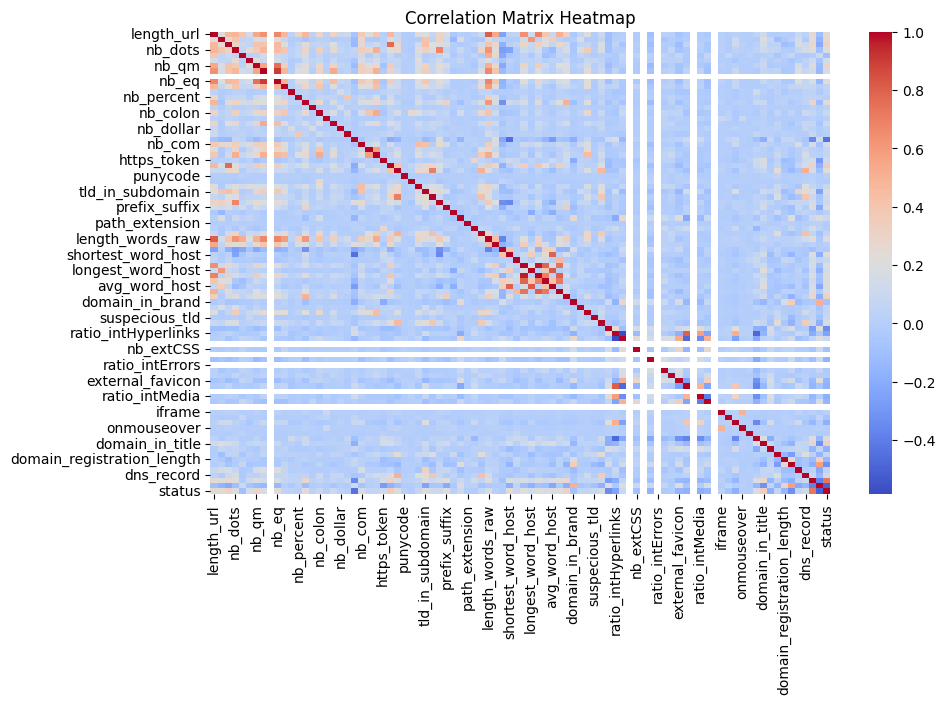

In [54]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [57]:
def preprocess_urls(urls):
    cleaned_urls = urls.apply(lambda x: re.sub(r'http[s]?://', '', x))  
    cleaned_urls = cleaned_urls.apply(lambda x: re.sub(r'www\.', '', x)) 
    cleaned_urls = cleaned_urls.apply(lambda x: re.sub(r'[^a-zA-Z0-9./]', '', x))  
    cleaned_urls = cleaned_urls.apply(lambda x: x.lower())  
    return cleaned_urls

In [58]:
url_features = preprocess_urls(df['url'])
other_features = df.drop(columns=['url', 'status'])

In [59]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(other_features)

In [60]:
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(scaled_features)

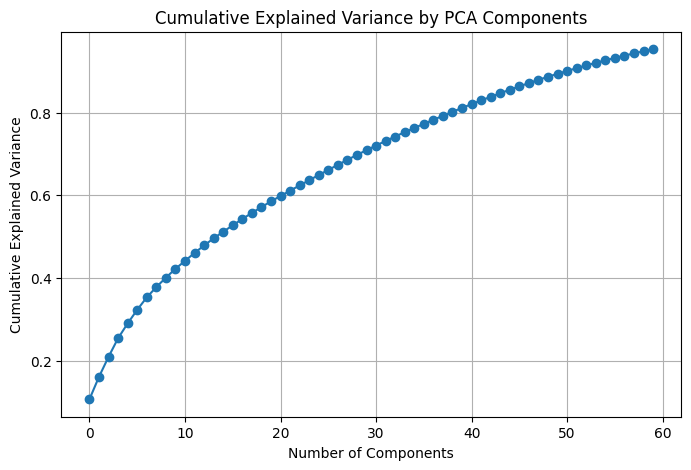

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [62]:
X_train_url, X_val_url, X_train_pca, X_val_pca, y_train, y_val = train_test_split(
    url_features, pca_features, df['status'].values, test_size=0.2, random_state=42)

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

C:\Users\dharu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initiali

In [93]:
def tokenize_urls(urls):
    return tokenizer(
        list(urls),
        padding='max_length',  
        truncation=True,
        max_length=512,  
        return_tensors='tf'
    )

In [94]:
train_url_encodings = tokenize_urls(X_train_url)
val_url_encodings = tokenize_urls(X_val_url)

In [95]:
train_data = {
    'input_ids': train_url_encodings['input_ids'],
    'attention_mask': train_url_encodings['attention_mask'],
    'pca_features': X_train_pca
}

val_data = {
    'input_ids': val_url_encodings['input_ids'],
    'attention_mask': val_url_encodings['attention_mask'],
    'pca_features': X_val_pca
}

In [96]:
bert_output = bert_model(input_ids, attention_mask=attention_mask, return_dict=True)['last_hidden_state']
bert_output = tf.reduce_mean(bert_output, axis=1)

In [97]:
pca_input = Input(shape=(X_train_pca.shape[1],), name='pca_features')
x = Dense(64, activation='relu')(pca_input)
x = Dropout(0.5)(x)
x = Dense(768, activation='relu')(x)

In [98]:
w1 = tf.Variable(1.0, trainable=True, name='w1')
w2 = tf.Variable(1.0, trainable=True, name='w2')

In [99]:
weighted_sum = w1 * bert_output + w2 * x

In [100]:
w1 = tf.Variable(1.0, trainable=True, name='w1')
w2 = tf.Variable(1.0, trainable=True, name='w2')

In [101]:
weighted_sum = w1 * bert_output + w2 * x

In [102]:
combined = Dense(64, activation='relu')(weighted_sum)
combined = Dropout(0.5)(combined)
outputs = Dense(len(label_encoder.classes_), activation='softmax')(combined)

In [103]:
model = Model(inputs=[input_ids, attention_mask, pca_input], outputs=outputs)

In [104]:
for layer in bert_model.layers:
    layer.trainable = True
bert_model.get_layer("bert").pooler.trainable = False

In [105]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [106]:
train_data = (train_url_encodings['input_ids'], train_url_encodings['attention_mask'], X_train_pca)
val_data = (val_url_encodings['input_ids'], val_url_encodings['attention_mask'], X_val_pca)

In [107]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    train_data,
    y_train,
    validation_data=(val_data, y_val),
    epochs=3,
    batch_size=4,
    callbacks=[early_stopping]
)

Epoch 1/3
1000/1000 [==============================] - 17466s 17s/step - loss: 0.4859 - accuracy: 0.8102 - val_loss: 0.1680 - val_accuracy: 0.9360
Epoch 2/3
1000/1000 [==============================] - 27491s 28s/step - loss: 0.2549 - accuracy: 0.9137 - val_loss: 0.1527 - val_accuracy: 0.9480
Epoch 3/3
1000/1000 [==============================] - 52444s 52s/step - loss: 0.2048 - accuracy: 0.9300 - val_loss: 0.1621 - val_accuracy: 0.9410


In [108]:
model.save("phishing.h5")
loss, accuracy = model.evaluate(val_data, y_val)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

32/32 [==============================] - 1743s 55s/step - loss: 0.1621 - accuracy: 0.9410
Validation Loss: 0.1621, Validation Accuracy: 0.9410


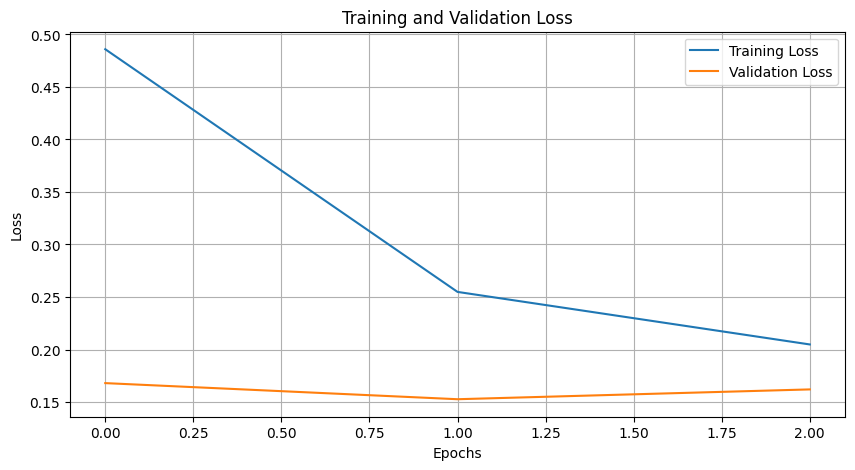

In [109]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

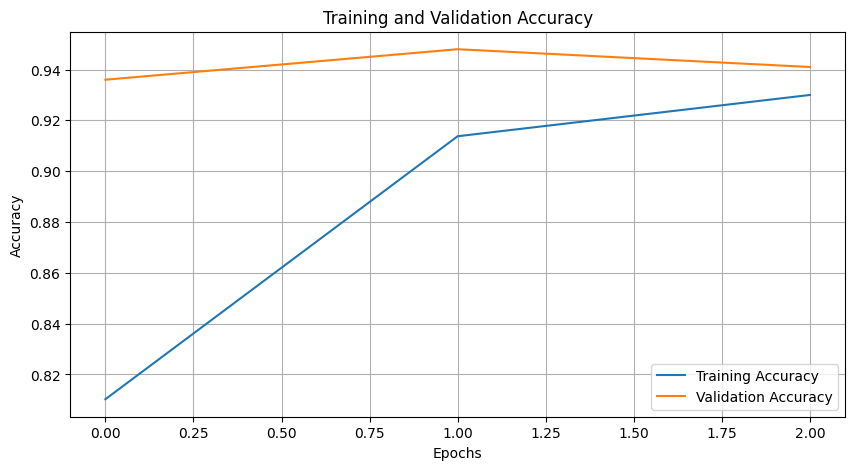

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [111]:
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)

32/32 [==============================] - 3938s 125s/step


In [112]:
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[483  39]
 [ 20 458]]


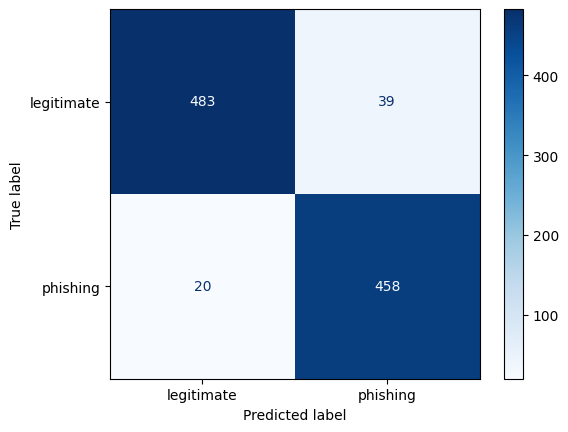

In [113]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [114]:
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

  legitimate       0.96      0.93      0.94       522
    phishing       0.92      0.96      0.94       478

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [115]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pca_features (InputLayer)      [(None, 60)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 64)           3904        ['pca_features[0][0]']           
                                                                                            